In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.10.0


## Load the data

In [3]:
df = pd.read_csv('../cleaned_data/FREN.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,7 DAYS STD DEV,14 DAYS MA,21 DAYS MA,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,
2012-10-17,-0.077792,-0.484714,-0.039585,-0.041007,0.008923,1.34241,1.016593,-1.845348,1.033444,0.147246,1.030312,0.440118
2012-10-18,-0.003835,1.422315,-0.007674,-0.010651,0.716706,1.34241,1.016593,-1.845348,1.042927,0.261864,1.030312,0.201081
2012-10-19,0.038425,1.517442,0.004293,0.002741,1.424489,1.34241,1.016593,-1.845348,1.052410,0.376483,1.030312,0.293018
2012-10-22,0.093893,1.628038,0.025567,0.019705,-1.406643,1.34241,1.016593,-1.845348,1.080859,0.720337,1.096678,0.274631
2012-10-23,0.141436,1.606590,0.046841,0.028634,-0.698860,1.34241,1.016593,-1.845348,1.090342,0.834955,1.096678,0.219468


### Plot the Close price - our target

Text(0.5, 1.0, 'FREN.JK Close Price')

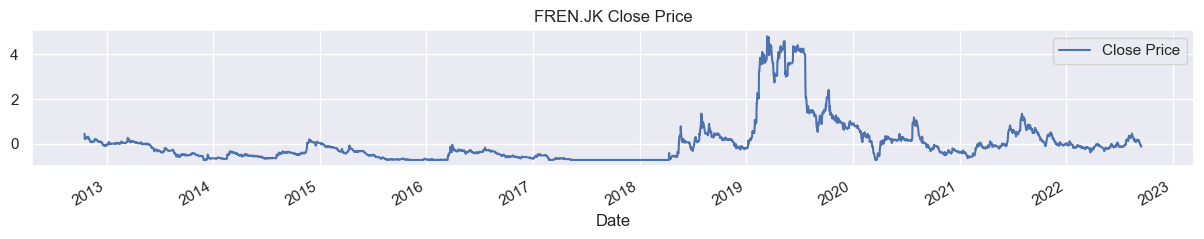

In [4]:
df['Close'].plot(figsize=(15,2))
plt.legend(['Close Price'])
plt.title('FREN.JK Close Price')

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [5]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Understanding Time Series Data

### Decompose time series into Trend, Seasonality, and Random Noise

In [7]:
import statsmodels.api as sm

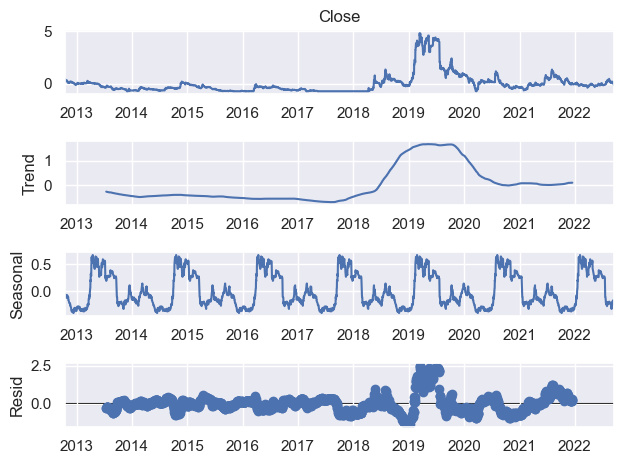

In [8]:
seas_d = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=365)
fig = seas_d.plot()
plt.show()

### ADF Test to check stationarity of the data

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout[f'critical value ({key})']=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)

In [10]:
test_adf(df['Close'], 'Stock Close Price')

Strong evidence for Null Hypothesis
Accept Null Hypothesis - Data is not Stationary
Data is NOT Stationary for Stock Close Price


In [11]:
"""
The Close price is not stationary. 
Therefore, differencing needs to be performed
"""
test_adf(df['Close'].diff(), 'Stock Close Price - First Difference')

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Stock Close Price - First Difference


### Plot ACF (Autocorrelation) and PACF (Partial Autocorrelation)

C:\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


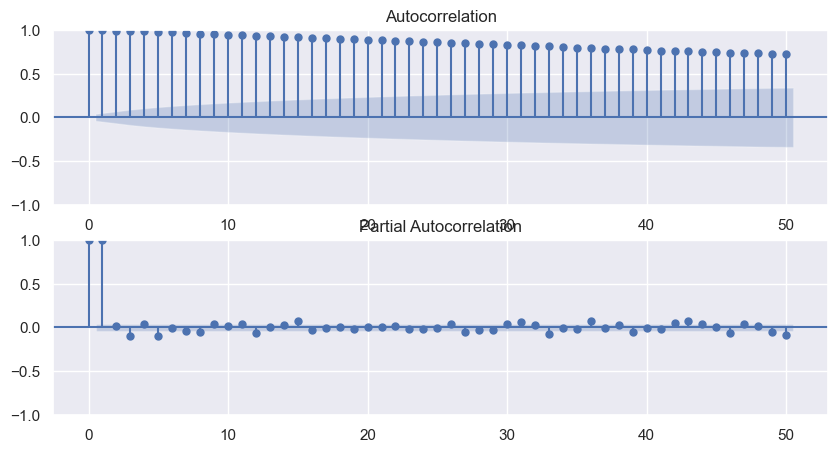

In [12]:
fig, ax = plt.subplots(2,1, figsize=(10,5))

fig = sm.tsa.graphics.plot_acf(df['Close'], lags=50, ax=ax[0])

fig = sm.tsa.graphics.plot_pacf(df['Close'], lags=50, ax=ax[1])
plt.show()

## Build the SARIMAX model

### Use auto_arima to determine the optimal p,d,q orders
We can determine p,d,q orders by using ACF and PACF plots above. However, a stepwise search will enable us to try out more optimal p,d,q orders.

In [13]:
from pmdarima.arima import auto_arima

In [14]:
step_wise_exog = auto_arima(train_labels, exogenous= train_features,
                           start_p=1, start_q=1, 
                           max_p=7, max_q=7, 
                           d=None, D=1, test='adf', max_d=7, seasonal=True, m=5,
                           trace=True, 
                           error_action='ignore', 
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[5] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=-86.232, Time=0.12 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=-2657.593, Time=0.78 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=-1199.123, Time=0.58 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=-88.213, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=-2220.760, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=-2910.712, Time=1.77 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=4.38 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=-119.517, Time=0.47 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=-2909.646, Time=2.56 sec
 ARIMA(1,0,1)(2,1,0)[5] intercept   : AIC=-2909.440, Time=2.01 sec
 ARIMA(0,0,1)(2,1,0)[5] intercept   : AIC=-1197.226, Time=1.14 sec
 ARIMA(2,0,1)(2,1,0)[5] intercept   : AIC=-2924.569, Time=4.24 sec
 ARIMA(2,0,1)(1,1,0)[5] intercept   : AIC=

In [15]:
step_wise_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1967
Model:             SARIMAX(3, 0, 2)x(0, 1, 2, 5)   Log Likelihood                1676.940
Date:                           Mon, 21 Nov 2022   AIC                          -3335.880
Time:                                   16:23:03   BIC                          -3285.645
Sample:                                        0   HQIC                         -3317.417
                                          - 1967                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.000     -0.832      0.405      -0.000       0.000
ar.L1          0.9566      0.148      6.442      0.000       0.666       1.248
ar.L2          0.3023      0.157      1.932      0.053      -0.004       0.609
ar.L3         -0.2685      0.087     -3.086      0.002      -0.439      -0.098
ma.L1         -0.0085      0.151     -0.056      0.955      -0.304       0.287
ma.L2         -0.1768      0.088     -2.007      0.045      -0.349      -0.004
ma.S.L5       -0.9430      0.013    -73.456      0.000      -0.968      -0.918
ma.S.L10      -0.0032      0.013     -0.244      0.808      -0.029       0.022
sigma2         0.0104   8.17e-05    127.467      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                   2.78   Jarque-Bera (JB):            176519.33
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):              22.11   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

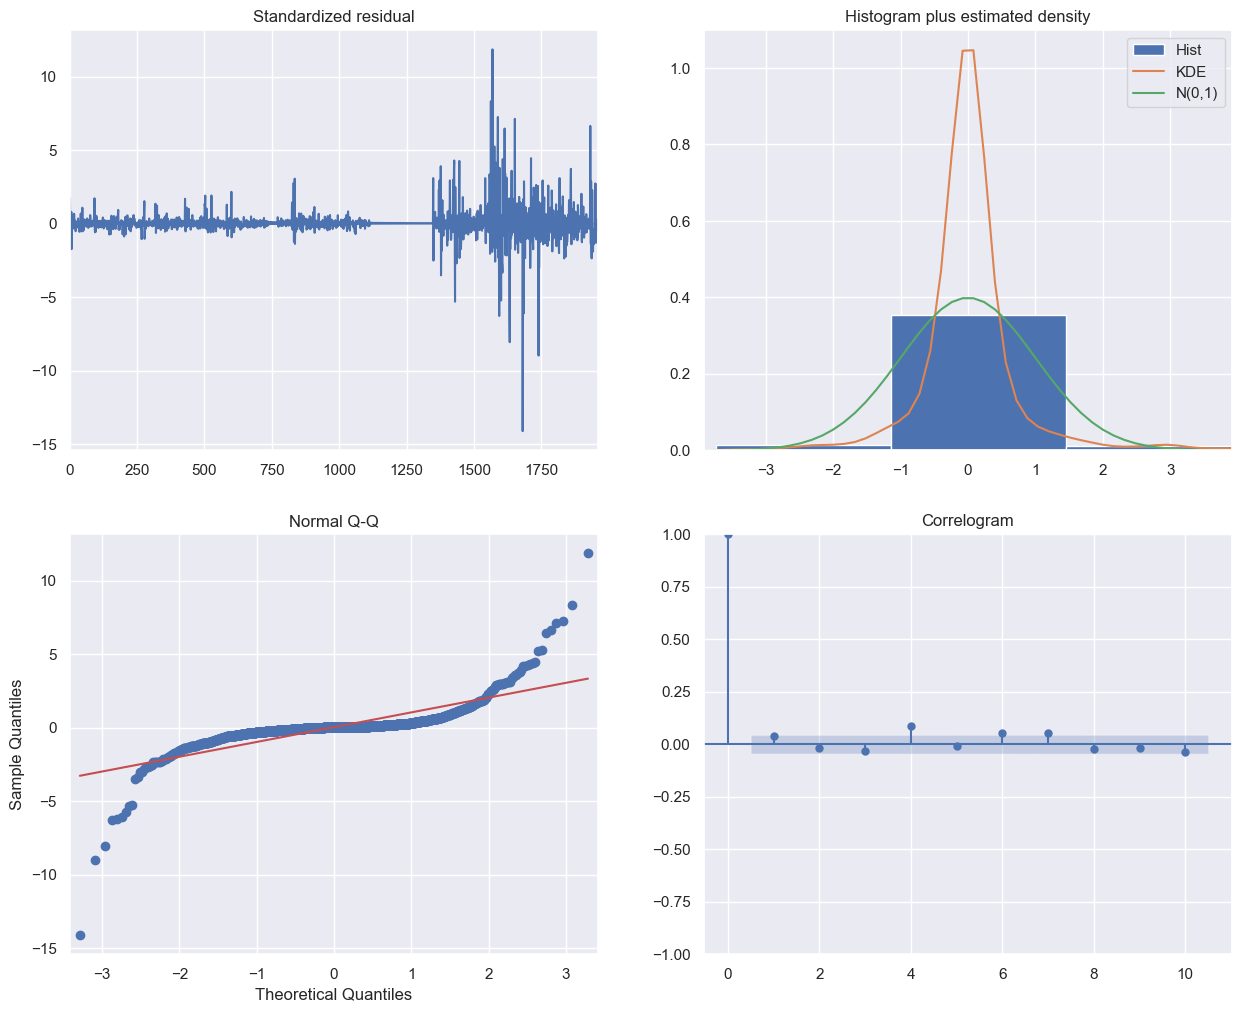

In [16]:
step_wise_exog.plot_diagnostics(figsize=(15,12));

### Fit the SARIMAX model using the best p,d,q orders

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [40]:
model_exog = SARIMAX(train_labels, exog=train_features,
                order=(3,0,2), seasonal_order=(0,1,2,5),
                enforce_invertibility=True, enforce_stationarity=True)

C:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [41]:
results = model_exog.fit()

C:\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1967
Model:             SARIMAX(3, 0, 2)x(0, 1, 2, 5)   Log Likelihood                1711.120
Date:                           Mon, 21 Nov 2022   AIC                          -3384.239
Time:                                   16:24:12   BIC                          -3278.187
Sample:                                        0   HQIC                         -3345.261
                                          - 1967                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.6115      0.105      5.828      0.000       0.406       0.817
7 DAYS STD DEV    -0.0518      0.003    -15.538      0.000      -0.058      -0.045
14 DAYS MA        -0.0825      0.147     -0.562      0.574      -0.370       0.205
21 DAYS MA         0.4344      0.112      3.876      0.000       0.215       0.654
dayofweek          0.0027      0.002      1.306      0.192      -0.001       0.007
quarter           -0.0357      0.033     -1.083      0.279      -0.100       0.029
month              0.4125      1.258      0.328      0.743      -2.053       2.878
year              -0.0620      0.093     -0.669      0.504      -0.244       0.120
dayofyear         -0.4010      1.276     -0.314      0.753      -2.903       2.101
dayofmonth         0.0359      0.107      0.335      0.738      -0.174       0.246
weekofyear        -0.0029      0.037     -0.078      0.937      -0.074       0.069
ar.L1              1.6740      1.930      0.867      0.386      -2.109       5.457
ar.L2             -0.9403      3.171     -0.297      0.767      -7.155       5.275
ar.L3              0.2188      1.313      0.167      0.868      -2.354       2.791
ma.L1             -0.7434      1.935     -0.384      0.701      -4.536       3.049
ma.L2              0.2439      1.394      0.175      0.861      -2.488       2.976
ma.S.L5           -1.0643      0.015    -68.749      0.000      -1.095      -1.034
ma.S.L10           0.0799      0.016      5.095      0.000       0.049       0.111
sigma2             0.0102   8.98e-05    114.078      0.000       0.010       0.010
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):            168486.07
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):              20.42   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [43]:
predictions = results.predict(start=train_len, end=len(df)-1, exog=test_features)

C:\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [44]:
actual_close = df[['Close']]
act = pd.DataFrame(actual_close.iloc[train_len:, 0])

In [45]:
predictions = pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index = test_features.index
predictions['Actual'] = act['Close']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

In [46]:
predictions

,Pred,Actual
Date,,
2020-09-10,-0.065030,-0.160836
2020-09-11,-0.102033,-0.179296
2020-09-14,-0.122964,-0.050079
2020-09-15,-0.134497,-0.086998
2020-09-16,-0.127276,-0.105458
...,...,...
2022-09-12,0.122080,-0.031620
2022-09-13,0.072011,-0.086998
2022-09-14,0.043727,-0.086998


<AxesSubplot: xlabel='Date'>

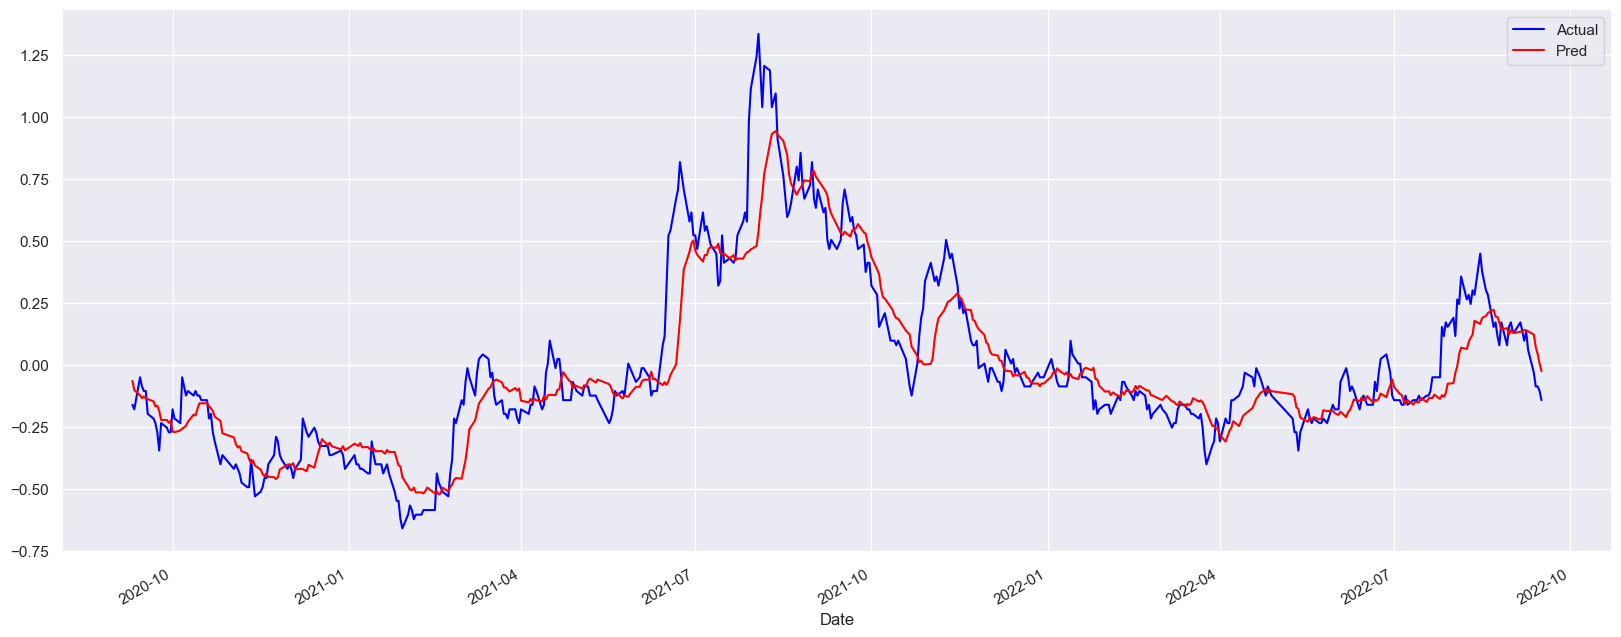

In [47]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

### Evaluation

In [48]:
from joblib import load

In [49]:
close_scaler = load('../feature_engineering/fren_close_scaler.bin')

In [50]:
inversed_pred = close_scaler.inverse_transform(np.array(predictions['Pred']).reshape(-1,1))
inversed_act = close_scaler.inverse_transform(np.array(predictions['Actual']).reshape(-1,1))

In [51]:
inversed = pd.DataFrame(inversed_pred)
inversed['Actual'] = inversed_act
inversed.rename({0:'Pred'}, axis=1, inplace=True)
inversed.index = test_labels.index
inversed.head(2)

,Pred,Actual
Date,,
2020-09-10,86.190083,81.0
2020-09-11,84.185527,80.0


**Plot Error Distribution**

In [52]:
def plotErrorHist(inversed_df):
    """
    Function to plot error histogram
    """
    error = inversed_df['Pred'] - inversed_df['Actual']
    plt.hist(error, bins=25)
    plt.xlabel('Prediction Error [Close]')
    _ = plt.ylabel('Count')

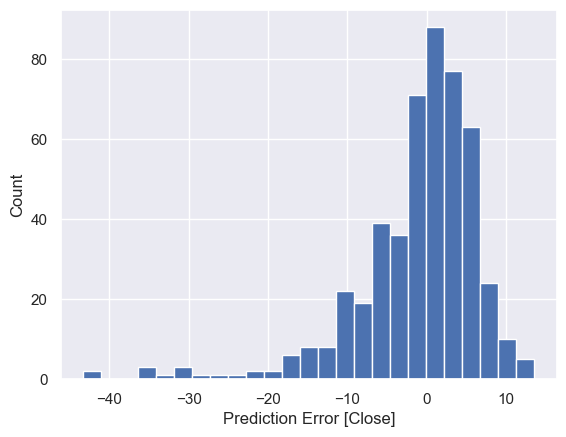

In [53]:
plotErrorHist(inversed)

**RMSE**

In [54]:
from statsmodels.tools.eval_measures import rmse

In [55]:
rmse(inversed['Pred'], inversed['Actual'])

7.988354005871858

**MAPE**

In [56]:
# mape
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [57]:
mape(inversed['Actual'], inversed['Pred'])

5.822420823568721

**R-squared**

In [58]:
from sklearn.metrics import r2_score

In [59]:
r2_score(inversed['Actual'], inversed['Pred'])

0.8260363741181951

### Save the model

In [60]:
from joblib import dump, load
dump(results, './models/fren.joblib') 

['./models/fren.joblib']

In [61]:
loaded = load('./models/fren.joblib')
loaded.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1967
Model:             SARIMAX(3, 0, 2)x(0, 1, 2, 5)   Log Likelihood                1711.120
Date:                           Mon, 21 Nov 2022   AIC                          -3384.239
Time:                                   16:24:57   BIC                          -3278.187
Sample:                                        0   HQIC                         -3345.261
                                          - 1967                                         
Covariance Type:                             opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
7 DAYS MA          0.6115      0.105      5.828      0.000       0.406       0.817
7 DAYS STD DEV    -0.0518      0.003    -15.538      0.000      -0.058      -0.045
14 DAYS MA        -0.0825      0.147     -0.562      0.574      -0.370       0.205
21 DAYS MA         0.4344      0.112      3.876      0.000       0.215       0.654
dayofweek          0.0027      0.002      1.306      0.192      -0.001       0.007
quarter           -0.0357      0.033     -1.083      0.279      -0.100       0.029
month              0.4125      1.258      0.328      0.743      -2.053       2.878
year              -0.0620      0.093     -0.669      0.504      -0.244       0.120
dayofyear         -0.4010      1.276     -0.314      0.753      -2.903       2.101
dayofmonth         0.0359      0.107      0.335      0.738      -0.174       0.246
weekofyear        -0.0029      0.037     -0.078      0.937      -0.074       0.069
ar.L1              1.6740      1.930      0.867      0.386      -2.109       5.457
ar.L2             -0.9403      3.171     -0.297      0.767      -7.155       5.275
ar.L3              0.2188      1.313      0.167      0.868      -2.354       2.791
ma.L1             -0.7434      1.935     -0.384      0.701      -4.536       3.049
ma.L2              0.2439      1.394      0.175      0.861      -2.488       2.976
ma.S.L5           -1.0643      0.015    -68.749      0.000      -1.095      -1.034
ma.S.L10           0.0799      0.016      5.095      0.000       0.049       0.111
sigma2             0.0102   8.98e-05    114.078      0.000       0.010       0.010
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):            168486.07
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):              20.42   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""